# Siamese Network trained with Triplet loss

The Notebook is divided in two part that are independant.
* 1- Training part
* 2- Testing part

The Training part is more focused on how the model is trained and the architecture chosen. While the second part just use the save of the best model and check the accuracy on pair images (like facial recognition).

## 1- Training

In [1]:
%reload_ext autoreload
%autoreload 2

from sklearn.datasets import fetch_lfw_pairs
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np
from data import triplet_data_generator, get_batch
import tensorflow as tf
from siamese_network_triplet_loss import SiameseNetwork, SiameseModel



2023-02-26 21:16:55.581732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-26 21:16:55.581771: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def visualize(image0, image1, image2):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1, image2], axis=1))
    plt.title("Anchor/Positive/Negative")
    plt.show()

def visualize_pair(image0, image1, similarity, label):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1], axis=1))
    title = "Same person" if label == 1 else "Not same person"
    plt.title(title)
    if similarity is not None:
        plt.suptitle("Similarity: {:.2f}".format(similarity))
    
    plt.show()

def plot_training_loss(loss):
    plt.plot(loss, label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()


### LFW Dataset

We still gonna use the LFW dataset but this time without pairs data.

In [3]:
lfw_train = fetch_lfw_people(resize=0.8, color=True)

X = lfw_train.images
X = X.astype("float32")
y = lfw_train.target

IMG_SHAPE = (X.shape[1], X.shape[2], X.shape[3])
X /= 255.
print(IMG_SHAPE)

(100, 75, 3)


So, we need to create by ourself the triplet arrays !

In [4]:
train_data = triplet_data_generator(X, y, IMG_SHAPE, 500)

### Plotting

Plotting the data is the perfect thing to do before doing anything. Just to check if the formatting and everything is alright !

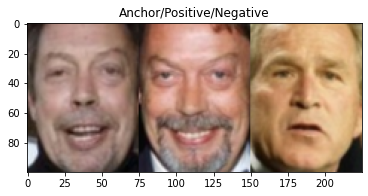

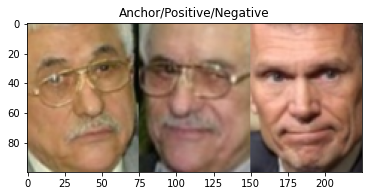

In [5]:
visualize(train_data[0][0], train_data[0][1], train_data[0][2])
visualize(train_data[1][0], train_data[1][1], train_data[1][2])

### Model

For the Notebook, we gonna use the **pre-trained** model Xception.
I tested other pre-trained model like ResNet and InceptionV3 but Xception was way better than the others for our task.

So, to build our Siamese Network model, we do 2 things:

* Build an embedding model that calculate an embedding vector of `embedding_dim` for each image

Simple illustration of what is embedding
![Simple illustration of embedding](./images/embedding_illustration.png)

* Build a siamese network model that take as parameter 3 Images, use the embedding model to have 3 vectors of `embedding_dim` dimensions and then, calculate the triplet loss with it

Architecture of the Siamese Network
![model architecture](./images/embedding_architecture.png)

Illustration of what triplet loss is trying to do
![calculate the triplet loss](./images/triplet_loss.png)
Minimize distance between anchor and positive and Maximize distance between anchor and negative.

2023-02-26 21:17:09.985043: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-26 21:17:09.985075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (phone-mobile): /proc/driver/nvidia/version does not exist
2023-02-26 21:17:09.986081: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


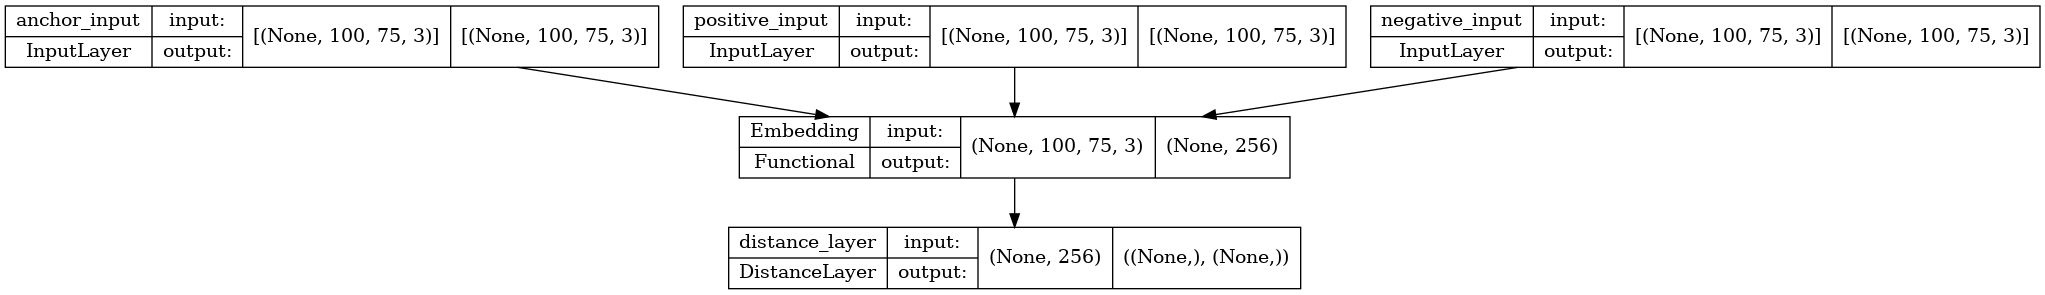

In [6]:
batch_size = 128
epochs = 10
lr = 1e-3  
triplet_loss_margin = 1
fine_tunning = True
embedding_dim = 256

## Unused
dropout_rate = 0.25
cnn_filters = [64, 64, 128]
##

# Embedding part
sn = SiameseNetwork(IMG_SHAPE, cnn_filters, epochs, lr, batch_size, fine_tunning, dropout_rate, embedding_dim)
distances_model = sn.get_siamese_distance_siamese_network()
embedding_layer = distances_model.layers[3]

# Siamese Part
siamese_model = SiameseModel(distances_model, margin=triplet_loss_margin)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

tf.keras.utils.plot_model(distances_model, show_shapes=True, to_file="images/architecture.png", show_layer_names=True)


*If you want more details on the model, I invite you to check the `siamese_network_triplet_loss.py` file.*

### Training

Let's now train our model on train_data !

In [7]:
loss_history = []

for i in range(epochs):

    print("=================")
    print("Epoch", i)
    epoch_loss = []
    for batch, _ in get_batch(train_data, batch_size):
        loss = siamese_model.train_on_batch(batch)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    loss_history.append(epoch_loss)
    print("Loss: ", epoch_loss)
    print("=================\n")

Epoch 0
Loss:  0.8559593558311462

Epoch 1
Loss:  0.7048821449279785

Epoch 2
Loss:  0.5784778594970703

Epoch 3
Loss:  0.386476069688797

Epoch 4
Loss:  0.23974862694740295

Epoch 5
Loss:  0.1532691977918148

Epoch 6
Loss:  0.09174507483839989

Epoch 7
Loss:  0.05142815783619881

Epoch 8
Loss:  0.045151665806770325

Epoch 9
Loss:  0.0357302175834775



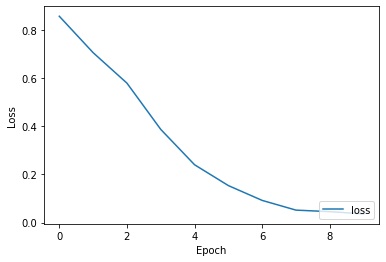

In [8]:
plot_training_loss(loss_history)

### Save model

This save let you (and me) use the testing part easely !

In [9]:
tf.keras.models.save_model(embedding_layer, 'embedding_layer')

2023-02-26 21:22:02.236164: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: embedding_layer/assets


## 2- Test part

Here, we gonna calculate the accuracy of the model based on the application with LFW pair images !
And finally, we gonna see the results with my own real face !

In [10]:
# Load model

embedding_layer = tf.keras.models.load_model('embedding_layer', compile=False)

As we did for the pair part, we take the lfw pairs scikit learn dataset to avoid us to treat the data.

In [11]:
lfw_pairs_test = fetch_lfw_pairs(subset="test", resize=0.8, color=True)
classes = list(lfw_pairs_test.target_names)
X_test = lfw_pairs_test.pairs
X_test = X_test.astype("float32")
X_test /= 255
IMG_SHAPE = (X_test[0].shape[1], X_test[0].shape[2], X_test[0].shape[3])
print(IMG_SHAPE)
y_test = lfw_pairs_test.target

(100, 75, 3)


Then, we have to use the embedding model (`embedding_layer` variable) to calculate the embedding for the pairs and we calculate similarities between pairs.

In [12]:
from tensorflow.keras import models
from scipy import spatial

def get_test_model(embedding_layer, IMG_SHAPE):
    anchor_input = tf.keras.Input(shape=IMG_SHAPE)
    anchor_embeddings = embedding_layer(anchor_input)
    embedding_model = models.Model(inputs=anchor_input, outputs=anchor_embeddings)
    return embedding_model

def test(X_test, embedding_layer, IMG_SHAPE):
    embedding_model = get_test_model(embedding_layer, IMG_SHAPE)

    embedding1 = embedding_model.predict(np.array(X_test[:, 0]))
    embedding2 = embedding_model.predict(np.array(X_test[:, 1]))

    similarities = []
    for i in range(len(embedding1)):
        similarity = 1 - spatial.distance.cosine(embedding1[i], embedding2[i])
        similarities.append(similarity)

    similarities = np.array(similarities)
    return similarities

In [13]:
similarities = test(X_test, embedding_layer, IMG_SHAPE)

Finally, we establish a threshold between the average of similarities of each class (Same person or Not same person)

In [14]:

not_same_people_idxs = similarities[y_test == 0]
same_people_idxs = similarities[y_test == 1]

avg_for_not_same_people = np.mean(not_same_people_idxs)
avg_for_same_people = np.mean(same_people_idxs)

classes = list(lfw_pairs_test.target_names)
print(classes[0], "(similarity mean)", avg_for_not_same_people)
print(classes[1], "(similarity mean)", avg_for_same_people)

threshold = (avg_for_not_same_people + avg_for_same_people) / 2
print("Threshold:", threshold)

binary_classification = np.zeros_like(similarities)
binary_classification[similarities >= threshold] = 1

accuracy = np.mean(binary_classification == y_test)
print("Accuracy:", accuracy)

Different persons (similarity mean) 0.3130554576670402
Same person (similarity mean) 0.6313980930270627
Threshold: 0.4722267753470515
Accuracy: 0.715


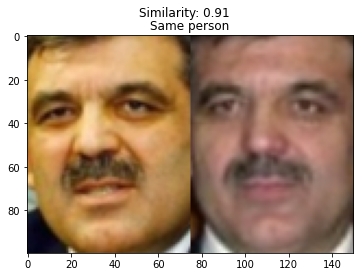

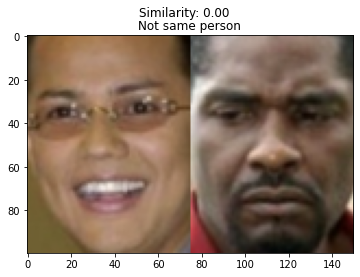

In [15]:
visualize_pair(X_test[0][0], X_test[0][1], similarities[0], y_test[0])
visualize_pair(X_test[650][0], X_test[650][1], similarities[650], y_test[650])

I feel so happy that works correctly :D
Now, we have to test on real image ... WITH MY OWN FACE !

Let's import the images

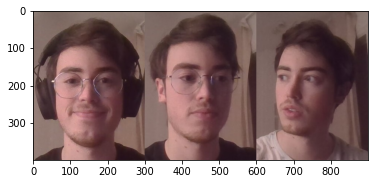

In [16]:
import cv2

webcam1 = cv2.imread('images/webcam1.jpg')
webcam2 = cv2.imread('images/webcam2.jpg')
webcam3 = cv2.imread('images/webcam3.jpg')

# to RGB
webcam1 = cv2.cvtColor(webcam1, cv2.COLOR_BGR2RGB)
webcam2 = cv2.cvtColor(webcam2, cv2.COLOR_BGR2RGB)
webcam3 = cv2.cvtColor(webcam3, cv2.COLOR_BGR2RGB)

plt.imshow(np.concatenate([webcam1, webcam2, webcam3], axis=1))

We have to force the images to be in the good shape ! (it normalizes in same time)

Original shape (400, 300, 3)
New shape (100, 75, 3)


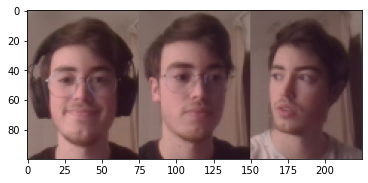

In [17]:
from skimage.transform import resize

print("Original shape", webcam1.shape)

webcam1_resized = resize(webcam1, (100, 75)).astype("float32")
webcam2_resized = resize(webcam2, (100, 75)).astype("float32")
webcam3_resized = resize(webcam3, (100, 75)).astype("float32")

print("New shape", webcam1_resized.shape)
plt.imshow(np.concatenate([webcam1_resized, webcam2_resized, webcam3_resized], axis=1))

Next, we have to normalize the data

Finally, we create a function that predict the similarity between 2 images and plot it !

In [18]:
def calc_similarity_and_plot(image1, image2, embedding_layer, IMG_SHAPE):
    data = np.array([[image1, image2]])
    similarity = test(data, embedding_layer, IMG_SHAPE)[0]
    label = 1 if similarity > threshold else 0
    visualize_pair(image1, image2, similarity, label)
    

Above 0.4722267753470515 we consider the model classifying as same person


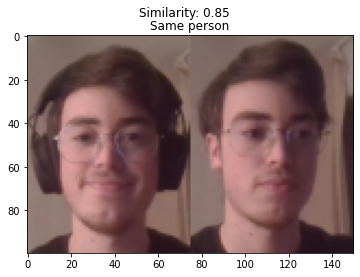

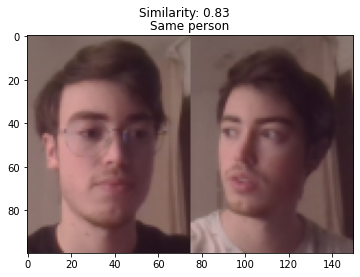

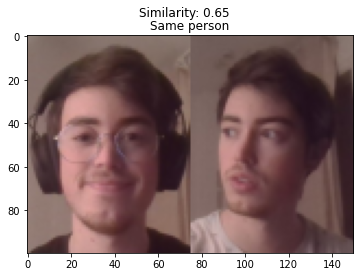

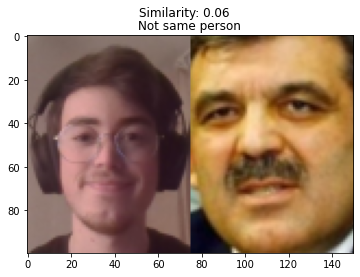

In [19]:
print("Above", threshold, "we consider the model classifying as same person")

calc_similarity_and_plot(webcam1_resized, webcam2_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam2_resized, webcam3_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam1_resized, webcam3_resized, embedding_layer, IMG_SHAPE)
calc_similarity_and_plot(webcam1_resized, X_test[0, 0], embedding_layer, IMG_SHAPE)

I am very happy of the results !
On the webcam images, I tried to change position + glasses + t-shirt to trick the model but it works well ! :)

Of course, the model that I submit with the notebook is not trained a lot AND can be EASELY improved !

If you want, you can propose a better model but doing a PR on the repo !